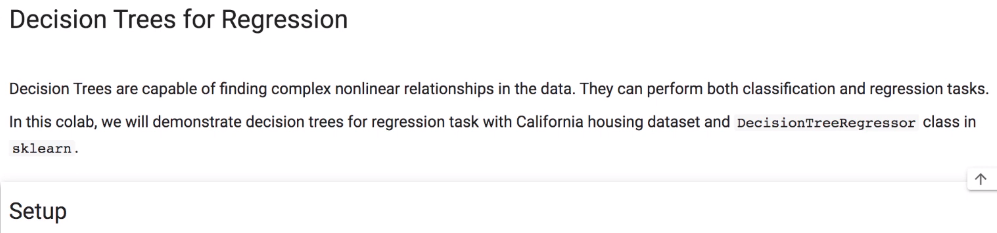

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [5]:
np.random.seed(306)

In [6]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

In [7]:
# fetch dataset
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

# train_test_split
com_train_features, test_features, com_train_labels, test_labels = train_test_split(
    features, labels, random_state=42
)

# train ---> train + dev split
train_features, dev_features, train_labels, dev_labels = train_test_split(
    com_train_features, com_train_labels, random_state=42
)

In [9]:
dt_reg_pipeline = Pipeline([
    ('feature_scaling', StandardScaler()),
    ('dt_reg', DecisionTreeRegressor(max_depth=3, random_state=42)),
])

dt_reg_cv_results = cross_validate(
    dt_reg_pipeline,
    com_train_features,
    com_train_labels,
    cv=cv,
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    return_estimator=True
)

dt_reg_train_error = -1 * dt_reg_cv_results['train_score']
dt_reg_test_error = -1 * dt_reg_cv_results['test_score']

print(f'Mean absolute error of linear regression model on the train set:\n'
      f'{dt_reg_train_error.mean():.3f} +/- {dt_reg_train_error.std():.3f}')
print(f'Mean absolute error of linear regression model on the train set:\n'
      f'{dt_reg_test_error.mean():.3f} +/- {dt_reg_test_error.std():.3f}')

Mean absolute error of linear regression model on the train set:
0.590 +/- 0.005
Mean absolute error of linear regression model on the train set:
0.593 +/- 0.007


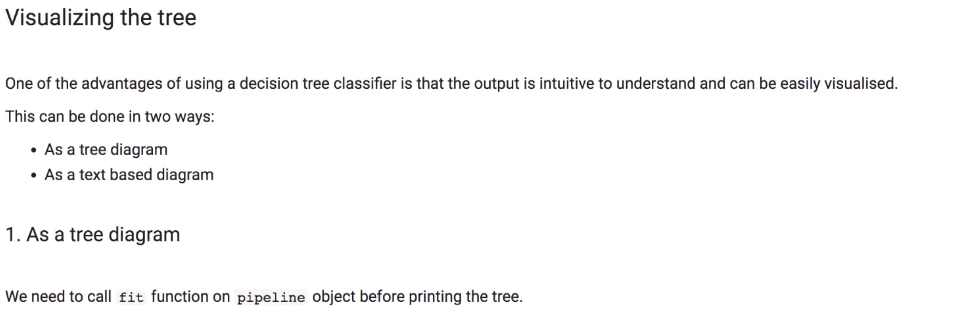

In [10]:
dt_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=3, random_state=42))])

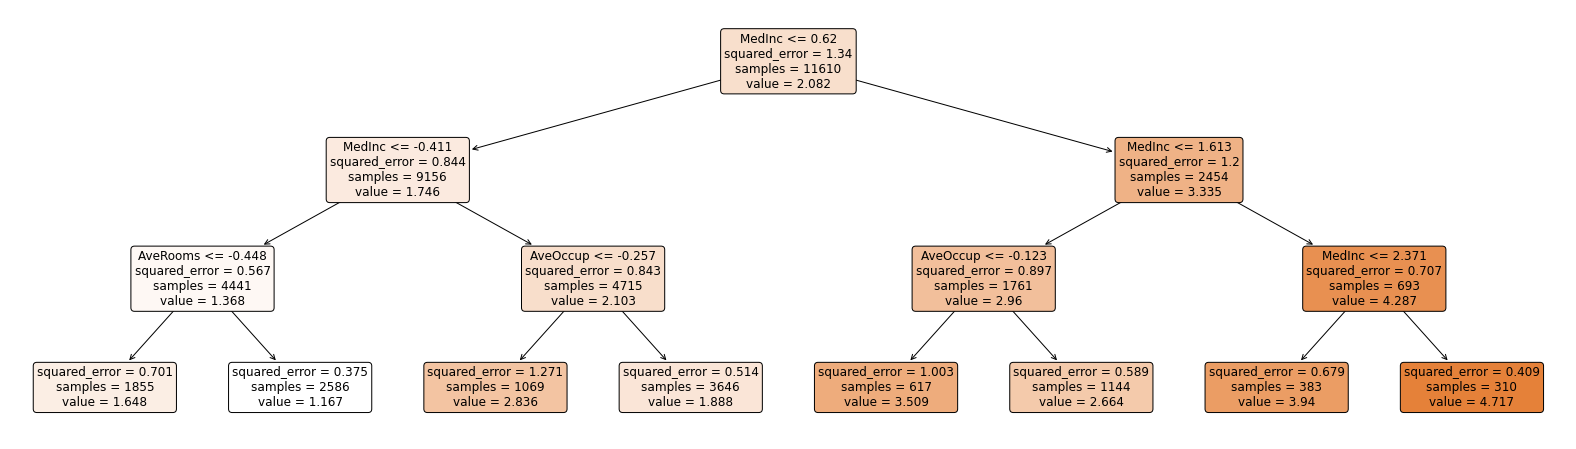

In [13]:
plt.figure(figsize=(28,8), facecolor='w')

# create the tree plot
a = tree.plot_tree(
    dt_reg_pipeline[-1],
    feature_names=features.columns,
    rounded=True,
    filled=True,
    fontsize=12
)
plt.show()

In [16]:
# export the decision rules
tree_rules = export_text(dt_reg_pipeline[-1])
print(tree_rules)

|--- feature_0 <= 0.62
|   |--- feature_0 <= -0.41
|   |   |--- feature_2 <= -0.45
|   |   |   |--- value: [1.65]
|   |   |--- feature_2 >  -0.45
|   |   |   |--- value: [1.17]
|   |--- feature_0 >  -0.41
|   |   |--- feature_5 <= -0.26
|   |   |   |--- value: [2.84]
|   |   |--- feature_5 >  -0.26
|   |   |   |--- value: [1.89]
|--- feature_0 >  0.62
|   |--- feature_0 <= 1.61
|   |   |--- feature_5 <= -0.12
|   |   |   |--- value: [3.51]
|   |   |--- feature_5 >  -0.12
|   |   |   |--- value: [2.66]
|   |--- feature_0 >  1.61
|   |   |--- feature_0 <= 2.37
|   |   |   |--- value: [3.94]
|   |   |--- feature_0 >  2.37
|   |   |   |--- value: [4.72]



In [17]:
test_labels_pred = dt_reg_pipeline.predict(test_features)

In [18]:
mae = mean_absolute_error(test_labels, test_labels_pred)
mse = mean_squared_error(test_labels, test_labels_pred)
r2 = r2_score(test_labels, test_labels_pred)

print('The model performance for testing set')
print('======================================')
print('MAE is', mae)
print('MSE is', mse)
print('R2 score is', r2)

The model performance for testing set
MAE is 0.6005762942842664
MSE is 0.6417557936098145
R2 score is 0.5150037690483743


In [21]:
param_grid = {
    'dt_reg__max_depth': range(1, 20),
    'dt_reg__min_samples_split': range(2, 8),
}

dt_grid_search = GridSearchCV(
    dt_reg_pipeline,
    param_grid=param_grid,
    n_jobs=2,
    cv=cv,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)

dt_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('feature_scaling', StandardScaler()),
                                       ('dt_reg',
                                        DecisionTreeRegressor(max_depth=3,
                                                              random_state=42))]),
             n_jobs=2,
             param_grid={'dt_reg__max_depth': range(1, 20),
                         'dt_reg__min_samples_split': range(2, 8)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [24]:
mean_train_error = -1 * dt_grid_search.cv_results_['mean_train_score'][dt_grid_search.best_index_]
mean_test_error = -1 * dt_grid_search.cv_results_['mean_test_score'][dt_grid_search.best_index_]
std_train_error = dt_grid_search.cv_results_['std_train_score'][dt_grid_search.best_index_]
std_test_error = dt_grid_search.cv_results_['std_test_score'][dt_grid_search.best_index_]

print(f'Best Mean absolute error of linear regression model on the train set:\n'
      f'{mean_train_error.mean():.3f} +/- {mean_train_error.std():.3f}')
print(f'Mean absolute error of linear regression model on the train set:\n'
      f'{mean_test_error.mean():.3f} +/- {mean_test_error.std():.3f}')

Best Mean absolute error of linear regression model on the train set:
0.278 +/- 0.000
Mean absolute error of linear regression model on the train set:
0.428 +/- 0.000


In [25]:
print('Mean cross validated score of the best estimator is:', -1*dt_grid_search.best_score_)

Mean cross validated score of the best estimator is: 0.4283313044233501


In [26]:
print('The best parameter value is:', dt_grid_search.best_params_)

The best parameter value is: {'dt_reg__max_depth': 11, 'dt_reg__min_samples_split': 5}


In [27]:
dt_reg_pipeline.set_params(
    dt_reg__max_depth=11,
    dt_reg__min_samples_split=5
).fit(com_train_features, com_train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('dt_reg',
                 DecisionTreeRegressor(max_depth=11, min_samples_split=5,
                                       random_state=42))])

In [28]:
test_labels_pred = dt_reg_pipeline.predict(test_features)

mae = mean_absolute_error(test_labels, test_labels_pred)
mse = mean_squared_error(test_labels, test_labels_pred)
r2 = r2_score(test_labels, test_labels_pred)

print('The model performance for testing set')
print('======================================')
print('MAE is', mae)
print('MSE is', mse)
print('R2 score is', r2)

The model performance for testing set
MAE is 0.4248952183820017
MSE is 0.4154957726373763
R2 score is 0.6859960039130073
